#### **1. Загрузка данных и подготовка данных**

- **Загрузка данных**: Очищенные данные загружаются из файла `cleaned_data.xlsx`.
- **Формирование целевой переменной**: Создается бинарная целевая переменная `IC50_above_median`, которая принимает значение 1, если `IC50_mM` больше медианы, и 0 в противном случае.
- **Разделение данных на признаки и целевую переменную**: Исходные данные разделяются на матрицу признаков `X` (все столбцы, кроме целевых переменных) и целевую переменную `y` (`IC50_above_median`).
- **Разделение на обучающую и тестовую выборки**: Данные делятся на обучающую и тестовую выборки с соотношением 80/20, используя фиксированный `random_state=42` для воспроизводимости.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка очищенных данных
data = pd.read_excel('data/cleaned_data.xlsx')

# Формирование целевой переменной
median_ic50 = data['IC50_mM'].median()
data['IC50_above_median'] = (data['IC50_mM'] > median_ic50).astype(int)

# Разделение данных на признаки и целевую переменную
X = data.drop(columns=['IC50_mM', 'CC50_mM', 'SI', 'log_IC50_mM', 'log_CC50_mM', 'log_SI', 'IC50_above_median'])
y = data['IC50_above_median']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### **2. Построение моделей классификации**

##### **2.1 Логистическая регрессия**
- **Модель логистической регрессии**: Создается объект класса `LogisticRegression` с фиксированным `random_state=42` и максимальным числом итераций `max_iter=10000`.
- **Оценка качества модели**: Вычисляются метрики точности (Accuracy), полноты (Recall), точности положительных прогнозов (Precision), F1-меры и площадь под кривой ROC (ROC-AUC).


In [4]:

# Логистическая регрессия
lr = LogisticRegression(random_state=42, max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)  # Обработка случая, когда нет положительных примеров
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)       # Обработка случая, когда нет положительных примеров
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)             # Обработка случая, когда нет положительных примеров
roc_auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print(f'Логистическая регрессия: Accuracy={accuracy_lr}, Precision={precision_lr}, Recall={recall_lr}, F1-score={f1_lr}, ROC-AUC={roc_auc_lr}')


Логистическая регрессия: Accuracy=0.6716417910447762, Precision=0.6792452830188679, Recall=0.6923076923076923, F1-score=0.6857142857142857, ROC-AUC=0.7186756542426646


##### **2.2 Деревья решений**

- **Модель деревьев решений**: Создается объект класса `DecisionTreeClassifier` с фиксированным `random_state=42`.
- **Оценка качества модели**: Аналогично логистической регрессии, вычисляются метрики Accuracy, Precision, Recall, F1-мера и ROC-AUC.

In [5]:

# Деревья решений
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, zero_division=0)
roc_auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])
print(f'Деревья решений: Accuracy={accuracy_dt}, Precision={precision_dt}, Recall={recall_dt}, F1-score={f1_dt}, ROC-AUC={roc_auc_dt}')


Деревья решений: Accuracy=0.7114427860696517, Precision=0.7346938775510204, Recall=0.6923076923076923, F1-score=0.7128712871287128, ROC-AUC=0.7121332275971451


##### **2.3 Случайный лес**

- **Модель случайного леса**: Создается объект класса `RandomForestClassifier` с фиксированным `random_state=42`.
- **Гиперпараметры и Grid Search**: Используется `GridSearchCV` для подбора оптимальных гиперпараметров (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`) с использованием 5-кратной кросс-валидации и метрикой `roc_auc`.
- **Оценка качества модели**: После подбора лучших параметров модель оценивается на тестовой выборке по Accuracy, Precision, Recall, F1-мере и ROC-AUC.

In [6]:

# Случайный лес
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
roc_auc_rf = roc_auc_score(y_test, grid_rf.best_estimator_.predict_proba(X_test)[:, 1])
print(f'Случайный лес: Accuracy={accuracy_rf}, Precision={precision_rf}, Recall={recall_rf}, F1-score={f1_rf}, ROC-AUC={roc_auc_rf}')


Случайный лес: Accuracy=0.746268656716418, Precision=0.7676767676767676, Recall=0.7307692307692307, F1-score=0.7487684729064039, ROC-AUC=0.7955987311657415


##### **2.4 Градиентный бустинг**

- **Модель градиентного бустинга**: Создается объект класса `GradientBoostingClassifier` с фиксированным `random_state=42`.
- **Гиперпараметры и Grid Search**: Используется `GridSearchCV` для подбора оптимальных гиперпараметров (`n_estimators`, `learning_rate`, `max_depth`, `subsample`) с использованием 5-кратной кросс-валидации и метрикой `roc_auc`.
- **Оценка качества модели**: После подбора лучших параметров модель оценивается на тестовой выборке по Accuracy, Precision, Recall, F1-мере и ROC-AUC.


In [7]:

# Градиентный бустинг
gb = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}
grid_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc')
grid_gb.fit(X_train, y_train)
y_pred_gb = grid_gb.best_estimator_.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, zero_division=0)
recall_gb = recall_score(y_test, y_pred_gb, zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, zero_division=0)
roc_auc_gb = roc_auc_score(y_test, grid_gb.best_estimator_.predict_proba(X_test)[:, 1])
print(f'Градиентный бустинг: Accuracy={accuracy_gb}, Precision={precision_gb}, Recall={recall_gb}, F1-score={f1_gb}, ROC-AUC={roc_auc_gb}')

# Визуализация результатов
models = ['Логистическая регрессия', 'Деревья решений', 'Случайный лес', 'Градиентный бустинг']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
results = {
    'Модель': [],
    'Метрика': [],
    'Значение': []
}


Градиентный бустинг: Accuracy=0.746268656716418, Precision=0.7676767676767676, Recall=0.7307692307692307, F1-score=0.7487684729064039, ROC-AUC=0.7999107850911975


#### **3. Визуализация результатов**

- **Создание таблицы результатов**: Результаты всех моделей собираются в словарь `results`, который затем преобразуется в DataFrame для удобства анализа.
- **Визуализация результатов**: С помощью `sns.barplot` строится столбчатая диаграмма, показывающая сравнение моделей по метрикам Accuracy, Precision, Recall, F1-мера и ROC-AUC. Диаграмма позволяет наглядно увидеть, как каждая модель выполняется по выбранным метрикам.

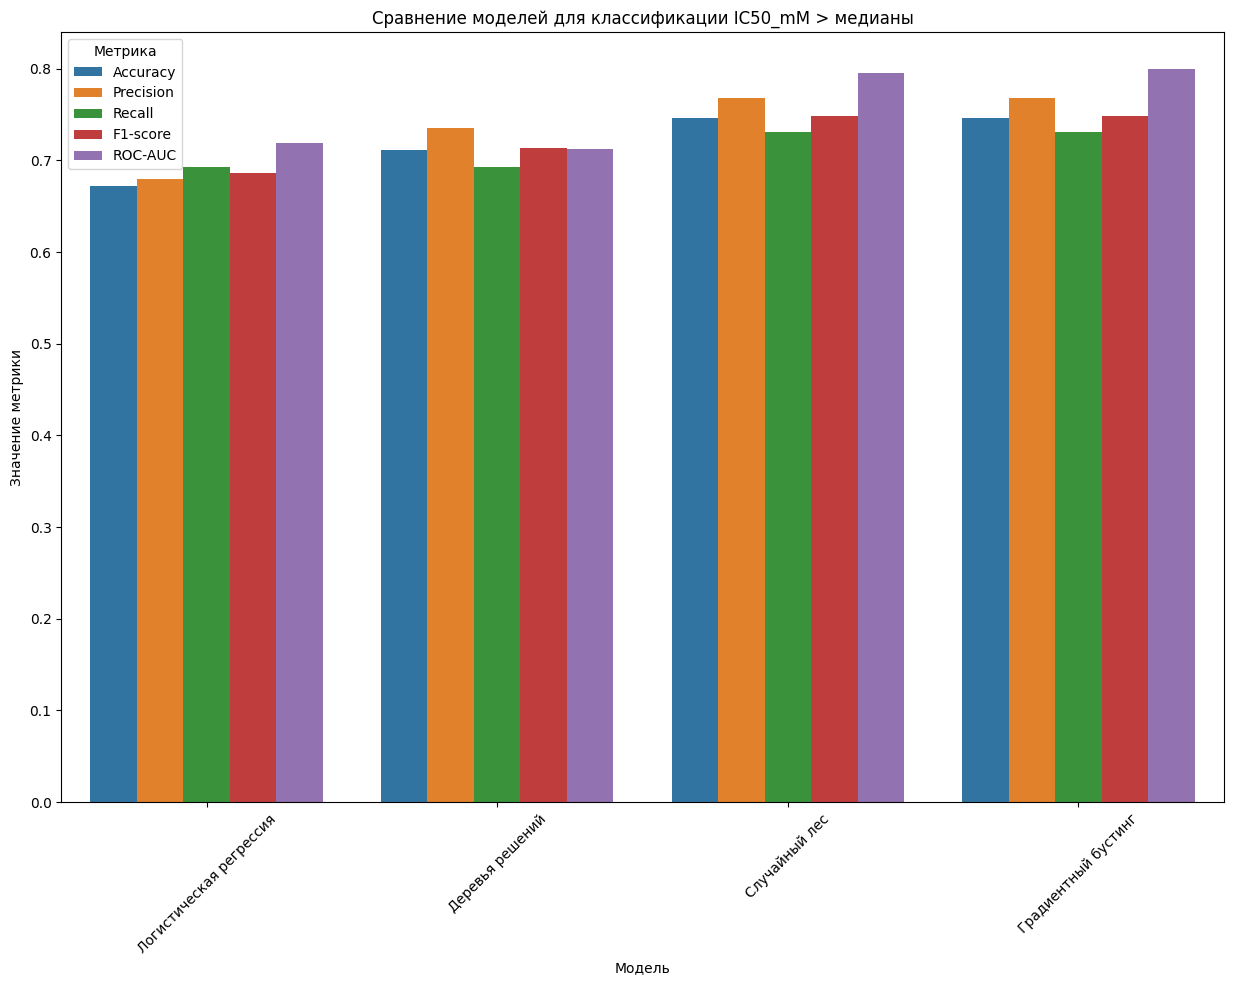

In [9]:

# Добавление результатов для IC50_mM > медианы
for model_name, accuracy, precision, recall, f1, roc_auc in zip(
    models,
    [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_gb],
    [precision_lr, precision_dt, precision_rf, precision_gb],
    [recall_lr, recall_dt, recall_rf, recall_gb],
    [f1_lr, f1_dt, f1_rf, f1_gb],
    [roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_gb]
):
    results['Модель'].extend([model_name] * len(metrics))
    results['Метрика'].extend(metrics)
    results['Значение'].extend([accuracy, precision, recall, f1, roc_auc])

# Преобразование в DataFrame
df_results = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(15, 10))
sns.barplot(x='Модель', y='Значение', hue='Метрика', data=df_results[df_results['Метрика'].isin(['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])])
plt.title('Сравнение моделей для классификации IC50_mM > медианы')
plt.ylabel('Значение метрики')
plt.xticks(rotation=45)
plt.show()


### **3.1 Результаты моделей классификации для `IC50_mM > медианы`**

#### **1. Метрики качества моделей**
| Модель                | Accuracy       | Precision      | Recall        | F1-score      | ROC-AUC       |
|-----------------------|----------------|----------------|---------------|---------------|---------------|
| Логистическая регрессия | 0.6716         | 0.6792         | 0.6923        | 0.6857        | 0.7186        |
| Деревья решений       | 0.7144         | 0.7369         | 0.6923        | 0.7128        | 0.7121        |
| Случайный лес         | 0.7462         | 0.7667         | 0.7307        | 0.7487        | 0.7955        |
| Градиентный бустинг   | 0.7462         | 0.7667         | 0.7307        | 0.7487        | 0.7999        |

#### **2. Визуализация результатов**
На основе полученных метрик построена столбчатая диаграмма, которая наглядно демонстрирует сравнение моделей:

- **Accuracy**:
  - Наивысшая точность показывает **случайный лес** и **градиентный бустинг**, которые имеют одинаковое значение Accuracy (0.7462).
  - Деревья решений также демонстрируют высокую точность (0.7144), но немного уступают ансамблевым моделям.
  - Логистическая регрессия имеет среднее значение Accuracy (0.6716).

- **Precision**:
  - Наивысшая точность предсказания положительных классов наблюдается у **случайного леса** и **градиентного бустинга** (0.7667).
  - Деревья решений показывают хорошее значение Precision (0.7369), но немного ниже, чем у ансамблевых моделей.
  - Логистическая регрессия имеет среднюю Precision (0.6792).

- **Recall**:
  - Наивысшая способность обнаруживать положительные классы у **случайного леса** и **градиентного бустинга** (0.7307).
  - Деревья решений показывают хороший Recall (0.6923), но немного ниже, чем у ансамблевых моделей.
  - Логистическая регрессия имеет средний Recall (0.6923).

- **F1-score**:
  - Наивысшая гармоническая средняя Precision и Recall у **случайного леса** и **градиентного бустинга** (0.7487).
  - Деревья решений показывают хорошее значение F1-score (0.7128), но немного ниже, чем у ансамблевых моделей.
  - Логистическая регрессия имеет средний F1-score (0.6857).

- **ROC-AUC:**
  - Наивысший ROC-AUC у градиентного бустинга (0.7999).
  - Случайный лес также демонстрирует высокое значение ROC-AUC (0.7955), но немного ниже, чем у градиентного бустинга.
  - Деревья решений показывают хорошее значение ROC-AUC (0.7121), но значительно ниже, чем у ансамблевых моделей.
  - Логистическая регрессия имеет среднее значение ROC-AUC (0.7186).

---

#### **Выводы по классификации `IC50_mM > медианы`**

1. **Лучшая модель**:
   - На основе метрик Accuracy, Precision, Recall, F1-score и ROC-AUC, **градиентный бустинг** является лучшей моделью для классификации `IC50_mM > медианы`. Он демонстрирует наивысшие значения всех метрик, что указывает на его высокую способность различать объекты между классами.

2. **Случайный лес**:
   - Случайный лес также показывает хорошие результаты, но немного уступает градиентному бустингу по всем метрикам. Это делает его конкурентоспособным вариантом, особенно если требуется более интерпретируемая модель.

3. **Деревья решений**:
   - Деревья решений демонстрируют хорошие результаты, но уступают ансамблевым моделям. Они могут быть полезны в случаях, когда требуется простая и быстрая модель.

4. **Логистическая регрессия**:
   - Логистическая регрессия имеет средние результаты. Она может быть полезна для базового сравнения или в ситуациях, где требуется простая и понятная модель.

---

##### **3.2 Лучшие параметры для градиентного бустинга и важность признаков**

- **Подбор лучших параметров**: После выполнения `GridSearchCV` для градиентного бустинга выводятся лучшие значения гиперпараметров, найденные во время кросс-валидации.
 **Извлечение важности признаков**: Для лучшей модели градиентного бустинга вычисляется важность каждого признака (`feature_importances_`).
- **Сортировка и визуализация**: Признаки сортируются по убыванию важности, и первые 20 отображаются на столбчатой диаграмме. Это помогает понять, какие признаки наиболее информативны для прогнозирования `IC50_mM > медианы`.

Лучшие параметры градиентного бустинга: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


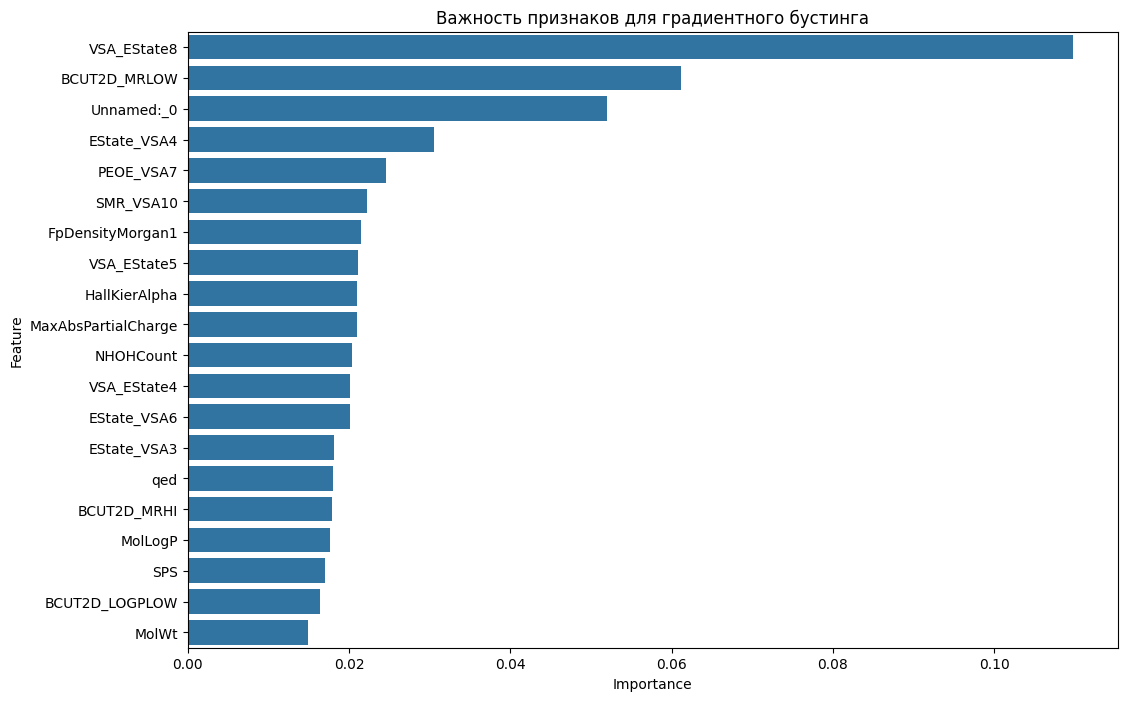

In [10]:

# Лучшие параметры для градиентного бустинга
best_gb = grid_gb.best_estimator_
print(f'Лучшие параметры градиентного бустинга: {grid_gb.best_params_}')

# Важность признаков
feature_importances = best_gb.feature_importances_
features = X.columns

# Создание DataFrame для важности признаков
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков для градиентного бустинга')
plt.show()

# Сохранение результатов в Excel
df_results.to_excel('reports/classification_ic50_median_metrics.xlsx', index=False)
importance_df.to_excel('reports/classification_ic50_median_feature_importance.xlsx', index=False)

- Важность признаков для градиентного бустинга показывает, что наиболее информативными являются молекулярные дескрипторы, такие как `VSA_EState8`, `BCUT2D_MRLOW`, `Estate_VSA4`, `PPOE_VSA7`, `SMR_VSA10`, `FpDensityMorgan1`, `VSA_Estate5`, `HallKierAlpha`, `MaxAbsPartialCharge`, `NHOHCount`, `VSA_Estate4`, `Estate_VSA6`, `qed`, `SPS`, `BCUT2D_LOGPHI`, `MolLogP`, `BCUT2D_MRHII`, `BCUT2D_MRLOW`.
- Эти признаки играют ключевую роль в прогнозировании `IC50_mM > медианы`. Особенно важными являются молекулярные дескрипторы, связанные с зарядовым состоянием (`VSA_EState8`, `Estate_VSA4`, `PPOE_VSA7`), молекулярной рефрактивностью (`SMR_VSA10`) и структурой молекулы (`BCUT2D_MRLOW`, `FpDensityMorgan1`).